# GRAE tests
-> Implemented manually as the import has dependency flaws

## Run Tests

In [6]:
from Main.test_manifold_algorithms import test_manifold_algorithms as tma
from mashspud import SPUD 
from Helpers.Grae import *
dc = tma("iris.csv", split = "random", verbose = 4)
spud = SPUD()
spud.fit(dc.split_A, dc.split_B, known_anchors=dc.anchors[:10])
spud.get_scores(dc.labels_doubled)

MDS initialized with 2 components

 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


(0.0004888888888888889, None, 0.9533333333333334)

RF score on full embedding: 0.9533333333333334
Cross Embedding score: None
Fraction of Samples Closest to thier Match: 0.0004888888888888889


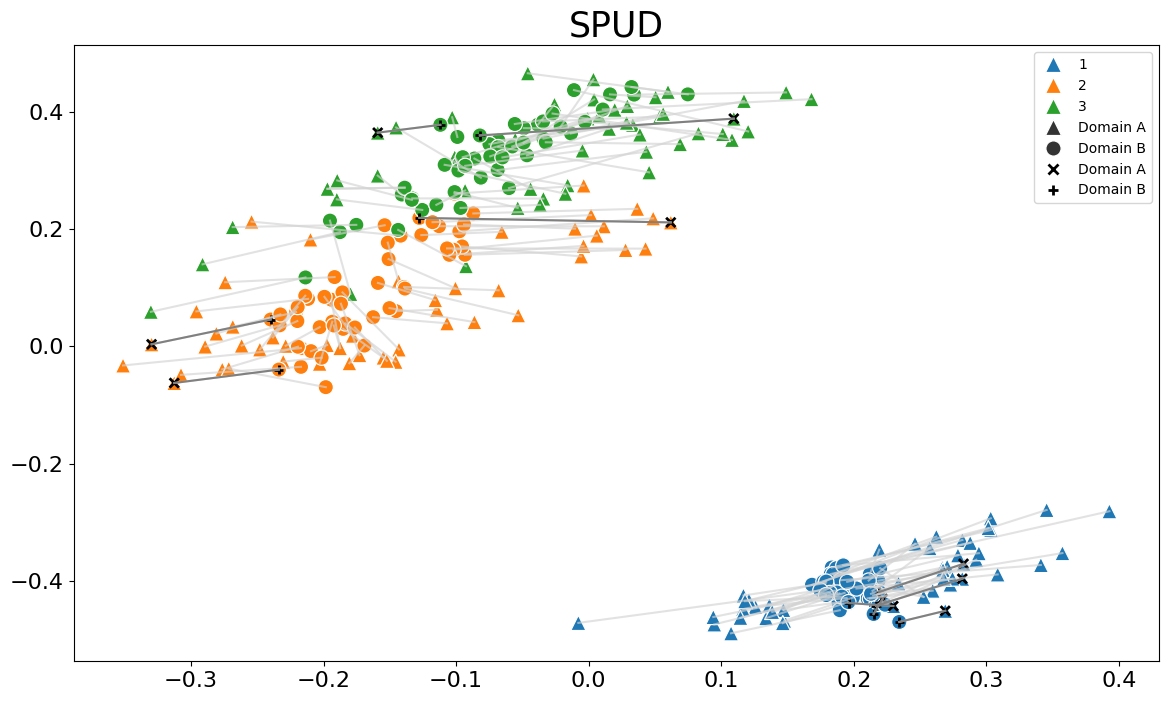

In [7]:
spud.plot_emb(labels = dc.labels_doubled)

In [8]:
dc.split_A[0].shape[0]

3

In [9]:
# Fit it to a BaseDataset
split_A = BaseDataset(x = dc.split_A, y = dc.labels, split_ratio = 0.8, random_state = 42, split = "none")

myGraeA = GRAEBase()
# Input data should be an instance of grae.data.BaseDataset
myGraeA.fit(split_A, emb=spud.emb[:spud.len_A]) #This fit might be expecting labels

In [16]:
split_A.data

tensor([[0.6250, 0.0417, 0.2222],
        [0.4167, 0.0417, 0.1667],
        [0.5000, 0.0417, 0.1111],
        [0.4583, 0.0417, 0.0833],
        [0.6667, 0.0417, 0.1944],
        [0.7917, 0.1250, 0.3056],
        [0.5833, 0.0833, 0.0833],
        [0.5833, 0.0417, 0.1944],
        [0.3750, 0.0417, 0.0278],
        [0.4583, 0.0000, 0.1667],
        [0.7083, 0.0417, 0.3056],
        [0.5833, 0.0417, 0.1389],
        [0.4167, 0.0000, 0.1389],
        [0.4167, 0.0000, 0.0000],
        [0.8333, 0.0417, 0.4167],
        [1.0000, 0.1250, 0.3889],
        [0.7917, 0.1250, 0.3056],
        [0.6250, 0.0833, 0.2222],
        [0.7500, 0.0833, 0.3889],
        [0.7500, 0.0833, 0.2222],
        [0.5833, 0.0417, 0.3056],
        [0.7083, 0.1250, 0.2222],
        [0.6667, 0.0417, 0.0833],
        [0.5417, 0.1667, 0.2222],
        [0.5833, 0.0417, 0.1389],
        [0.4167, 0.0417, 0.1944],
        [0.5833, 0.1250, 0.1944],
        [0.6250, 0.0417, 0.2500],
        [0.5833, 0.0417, 0.2500],
        [0.500

In [11]:
myGraeA.data_shape

torch.Size([3])

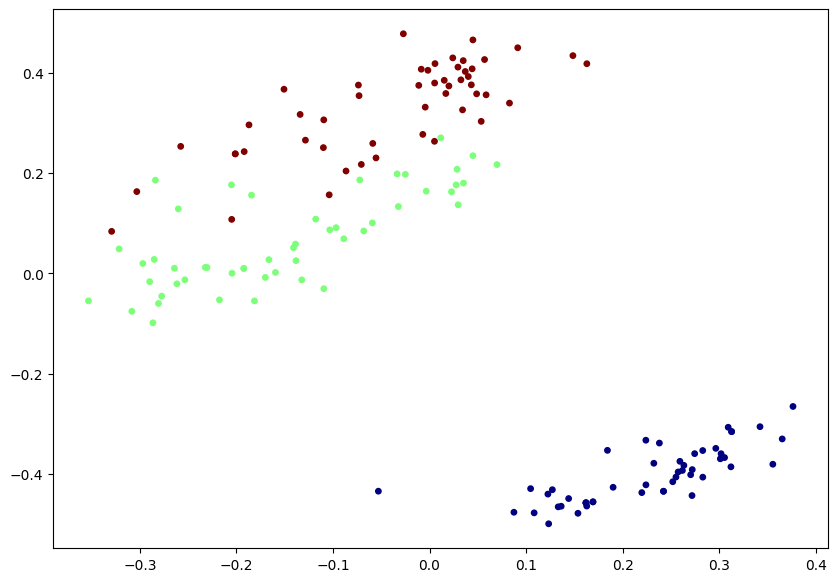

In [12]:
myGraeA.plot(split_A)

### Test with second domain?

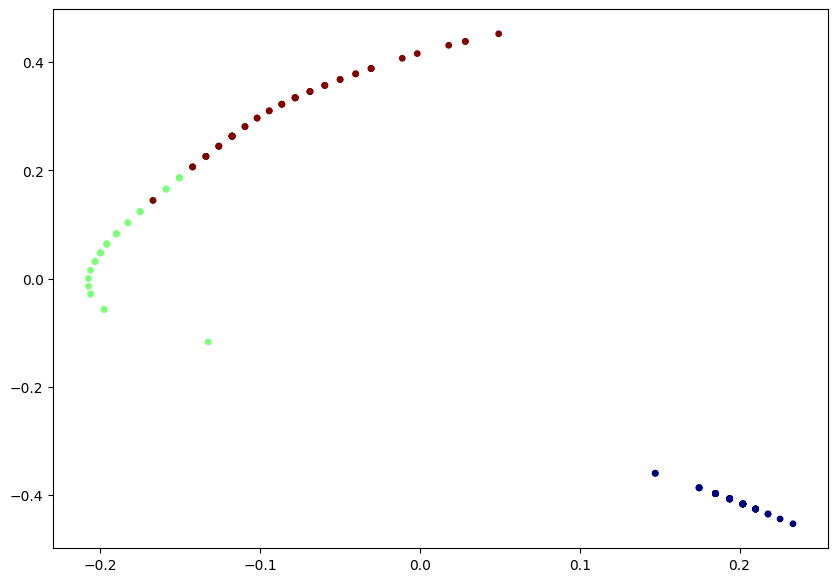

In [13]:
# Fit it to a BaseDataset
split_B = BaseDataset(x = dc.split_B, y = dc.labels, split_ratio = 0.8, random_state = 42, split = "none")

myGraeB = GRAEBase()

# Input data should be an instance of grae.data.BaseDataset
myGraeB.fit(split_B, emb=spud.emb[spud.len_A:]) #This fit might be expecting labels

myGraeB.plot(split_B)

## Test with Embedding broken up

In [6]:
# Testing with GRAE
from Helpers.Grae import *
from Main.test_manifold_algorithms import test_manifold_algorithms as tma
dc = tma(csv_file="iris.csv", split = "random", percent_of_anchors= [0.2], verbose = 4, random_state= 42)
import random

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score

def train_and_score_models(X_train, X_test, y_train, y_test, task_type="auto"):
    """
    Trains and evaluates KNN and Random Forest models using the specified evaluation metric.

    Parameters:
        X_train: array-like
            Training feature data.
        X_test: array-like
            Testing feature data.
        y_train: array-like
            Training labels or target values.
        y_test: array-like
            Testing labels or target values.
        task_type: str
            The type of task. Can be "regression", "classification", or "auto".
            - "regression": Uses R² score for evaluation.
            - "classification": Uses accuracy score for evaluation.
            - "auto": Automatically detects task type.

    Returns:
        dict: A dictionary containing the scores for KNN and Random Forest models.
    """
    # Detect task type if not explicitly provided
    if task_type == "auto":
        if y_train.dtype.kind in {'i', 'u', 'b'}:  # Integer, unsigned, or boolean
            task_type = "classification"
        else:
            task_type = "regression"

    # Choose model types based on task
    if task_type == "classification":
        knn_model = KNeighborsClassifier()
        rf_model = RandomForestClassifier(random_state=42)
        metric = accuracy_score
    elif task_type == "regression":
        knn_model = KNeighborsRegressor()
        rf_model = RandomForestRegressor(random_state=42)
        metric = r2_score
    else:
        raise ValueError("Invalid task_type. Choose from 'regression', 'classification', or 'auto'.")

    # Train and predict with KNN
    knn_model.fit(X_train, y_train)
    knn_predictions = knn_model.predict(X_test)
    knn_score = metric(y_test, knn_predictions)

    # Train and predict with Random Forest
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    rf_score = metric(y_test, rf_predictions)

    # Return the results
    return {
        "KNN Score": knn_score,
        "Random Forest Score": rf_score,
        "Task Type": task_type
    }

def create_unique_pairs(max_num, num_pairs):
    """
    Generates a list of unique pairs of random numbers.

    Parameters:
        max_num (int): The maximum number (exclusive) for the range of random numbers.
        num_pairs (int): The number of pairs to generate.

    Returns:
        list: A list of unique pairs of random numbers.
    """
    # Ensure there are enough numbers for unique selection
    if num_pairs * 2 > max_num:
        raise ValueError("Not enough unique numbers to create the specified number of pairs.")
    
    # Generate a pool of unique numbers
    random.seed(42)
    numbers = random.sample(range(max_num), num_pairs)
    
    # Create pairs from the list of unique numbers
    pairs = [[numbers[i], numbers[i]] for i in range(0, len(numbers))]
    
    return pairs

MDS initialized with 2 components

 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [7]:
from sklearn.model_selection import train_test_split
X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(dc.split_A, dc.labels, test_size=0.2, random_state=42)
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(dc.split_B, dc.labels, test_size=0.2, random_state=42)

labels_doubled = np.hstack((y_A_train, y_A_test, y_B_train, y_B_test))
train_labels = np.hstack((y_A_train, y_B_train))

In [8]:
#To avoid using the data on the text and Train, we will need to split it
y_A_train == y_B_train

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

Time it took to compute SGDM:  0.0
Time it took to execute graphtools.Graph functions:  0.16
Time it took to execute merge_graphs function:  0.0
Time it took to execute get_block function:  0.01
<><><><><><><><><><><><><>  Processed Finished  <><><><><><><><><><><><><>
Time it took to calculate the embedding: 0.45
RF-GAP score is accuracy
MSE score 0.005926402751356363 on training data
Classification or R2 score {'KNN Score': 0.85, 'Random Forest Score': 0.8833333333333333, 'Task Type': 'classification'}


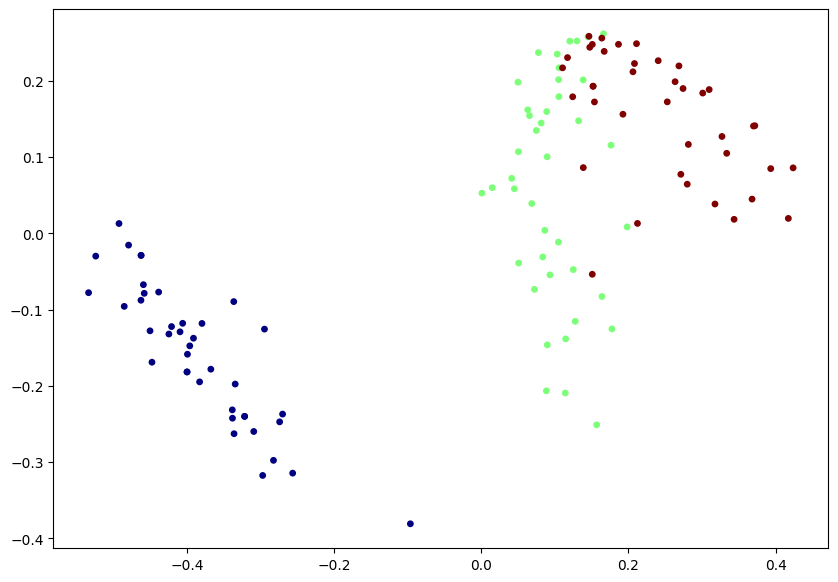

In [9]:
#Initialize SPUD Class
spud = SPUD(knn = 3, verbose = 4)

#Fit SPUD
spud.fit(dataA = X_A_train, dataB = X_B_train, known_anchors = create_unique_pairs(len(X_A_train), 10))
spud.get_scores(train_labels, n_components = 2)
# Fit it to a Split A
split_A = BaseDataset(x = X_A_train, y = y_A_train, split_ratio = 0.8, random_state = 42, split = "none")

myGraeA = GRAEBase()
# Input data should be an instance of grae.data.BaseDataset
myGraeA.fit(split_A, emb=spud.emb[:spud.len_A]) #This fit might be expecting labels

pred, mse = myGraeA.score(split_A)

print(f"MSE score {mse['MSE']} on training data")
print(f"Classification or R2 score {train_and_score_models(spud.emb[:len(y_A_train)], pred, y_A_train, y_A_train)}")

myGraeA.plot(split_A)

MSE score 0.00026580289704725146 on training data
Classification or R2 score {'KNN Score': 0.9416666666666667, 'Random Forest Score': 0.95, 'Task Type': 'classification'}


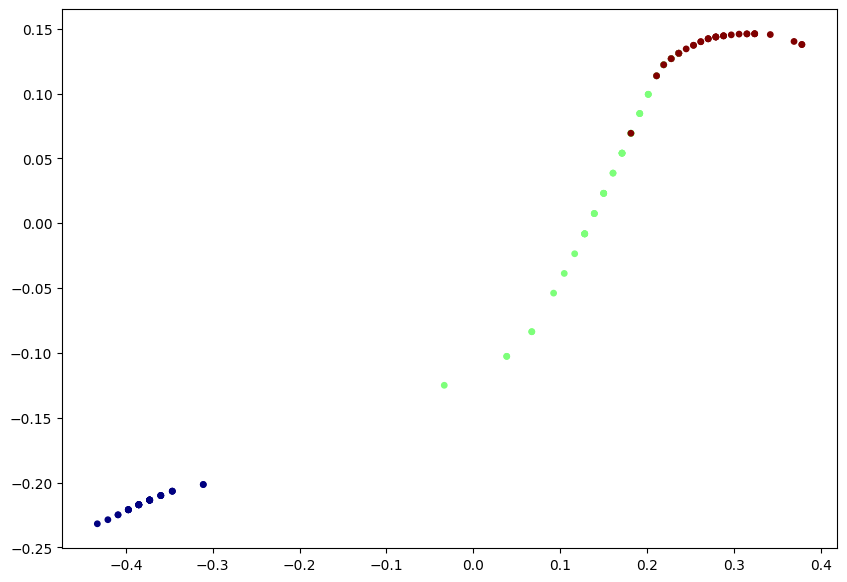

In [10]:
# Fit it to a Split A
split_B = BaseDataset(x = X_B_train, y = y_B_train, split_ratio = 0.8, random_state = 42, split = "none")

myGraeB = GRAEBase()

# Input data should be an instance of grae.data.BaseDataset
myGraeB.fit(split_B, emb=spud.emb[spud.len_A:]) 
pred, mse = myGraeB.score(split_B)

print(f"MSE score {mse['MSE']} on training data")
print(f"Classification or R2 score {train_and_score_models(spud.emb[len(y_A_train):], pred, y_B_train, y_B_train)}")

myGraeB.plot(split_B)


MSE score 0.0061540077440440655 on test data
Classification or R2 score {'KNN Score': 0.9333333333333333, 'Random Forest Score': 0.9666666666666667, 'Task Type': 'classification'}


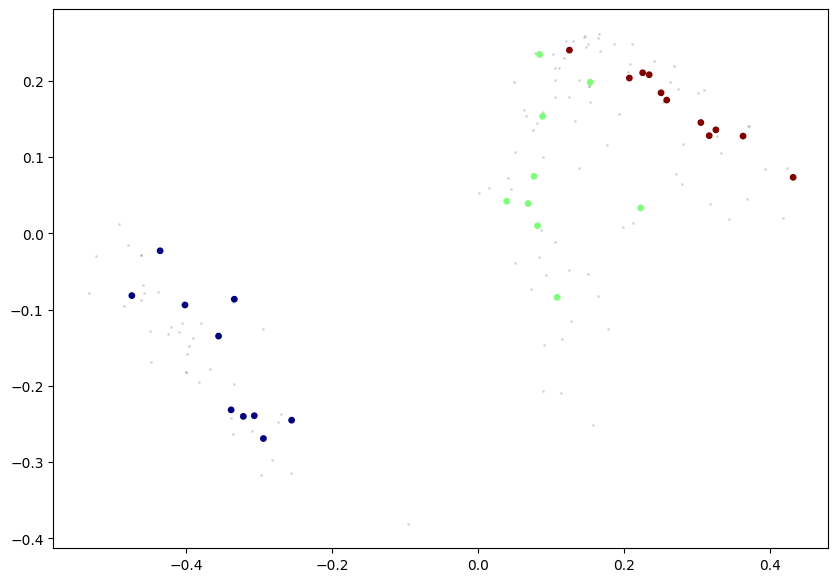

In [11]:

# Predictions
# Fit it to a Split A
testA = BaseDataset(x = X_A_test, y = y_A_test, split_ratio = 0.8, random_state = 42, split = "none")
pred, mse = myGraeA.score(testA)

print(f"MSE score {mse['MSE']} on test data")
print(f"Classification or R2 score {train_and_score_models(spud.emb, pred, train_labels, y_A_test)}") # Trained on embedding, predict on the test
myGraeA.plot(x_train = split_A, x_test = testA)

MSE score 0.000365953630534932 on test data
Classification or R2 score {'KNN Score': 1.0, 'Random Forest Score': 0.9666666666666667, 'Task Type': 'classification'}


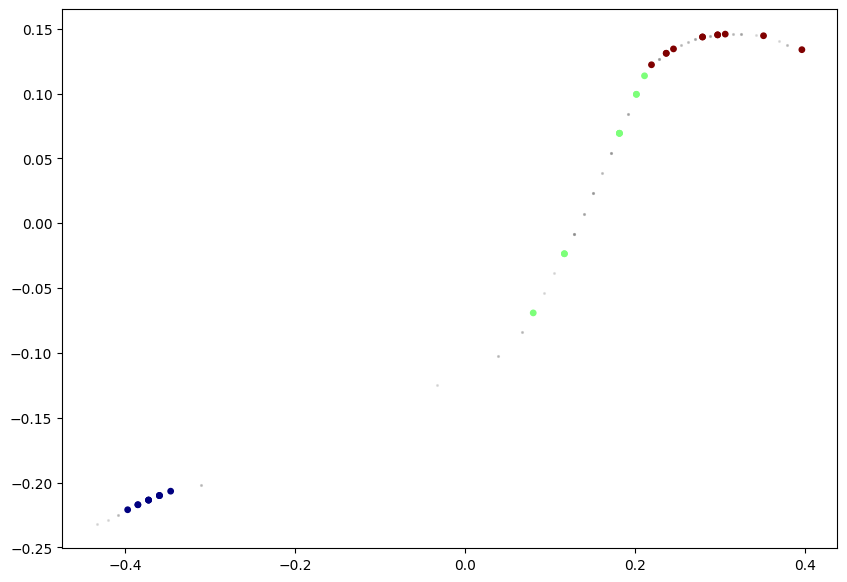

In [12]:

# Predictions
# Fit it to a Split A
testB = BaseDataset(x = X_B_test, y = y_B_test, split_ratio = 0.8, random_state = 42, split = "none")
pred, mse = myGraeB.score(testB)

print(f"MSE score {mse['MSE']} on test data")
print(f"Classification or R2 score {train_and_score_models(spud.emb, pred, train_labels, y_B_test)}")
myGraeB.plot(x_train = split_B, x_test = testB)
## Making predictions?

In [13]:
pred, 

(array([[ 0.20155756,  0.09938866],
        [-0.34654194, -0.20667945],
        [ 0.3963287 ,  0.13380894],
        [ 0.18159473,  0.06934076],
        [ 0.21114244,  0.11365856],
        [-0.3725866 , -0.21354237],
        [ 0.08015841, -0.06918654],
        [ 0.23668008,  0.13104254],
        [ 0.18159473,  0.06934076],
        [ 0.11684567, -0.02356092],
        [ 0.23668008,  0.13104254],
        [-0.3851232 , -0.2171359 ],
        [-0.39715728, -0.22099218],
        [-0.3725866 , -0.21354237],
        [-0.3725866 , -0.21354237],
        [ 0.20155756,  0.09938866],
        [ 0.2971708 ,  0.14524601],
        [ 0.11684567, -0.02356092],
        [ 0.18159473,  0.06934076],
        [ 0.2793986 ,  0.14362237],
        [-0.35978076, -0.21004611],
        [ 0.21934976,  0.12217715],
        [-0.35978076, -0.21004611],
        [ 0.2793986 ,  0.14362237],
        [ 0.35120365,  0.14456768],
        [ 0.24524249,  0.13441582],
        [ 0.2971708 ,  0.14524601],
        [ 0.30613732,  0.145

# Domain Reconstruction

## Shared Latent Space Autoencoder Architecture Below

Design a two-branch autoencoder:
- One encoder for Domain A and another for Domain B.
- Both encoders map inputs to a shared latent space (z-level).
- Two decoders (one for each domain) reconstruct data from the shared latent space.

MDS initialized with 2 components

 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)
RF score on full embedding: 0.9466666666666667
Cross Embedding score: None
Fraction of Samples Closest to thier Match: 0.002088888888888889


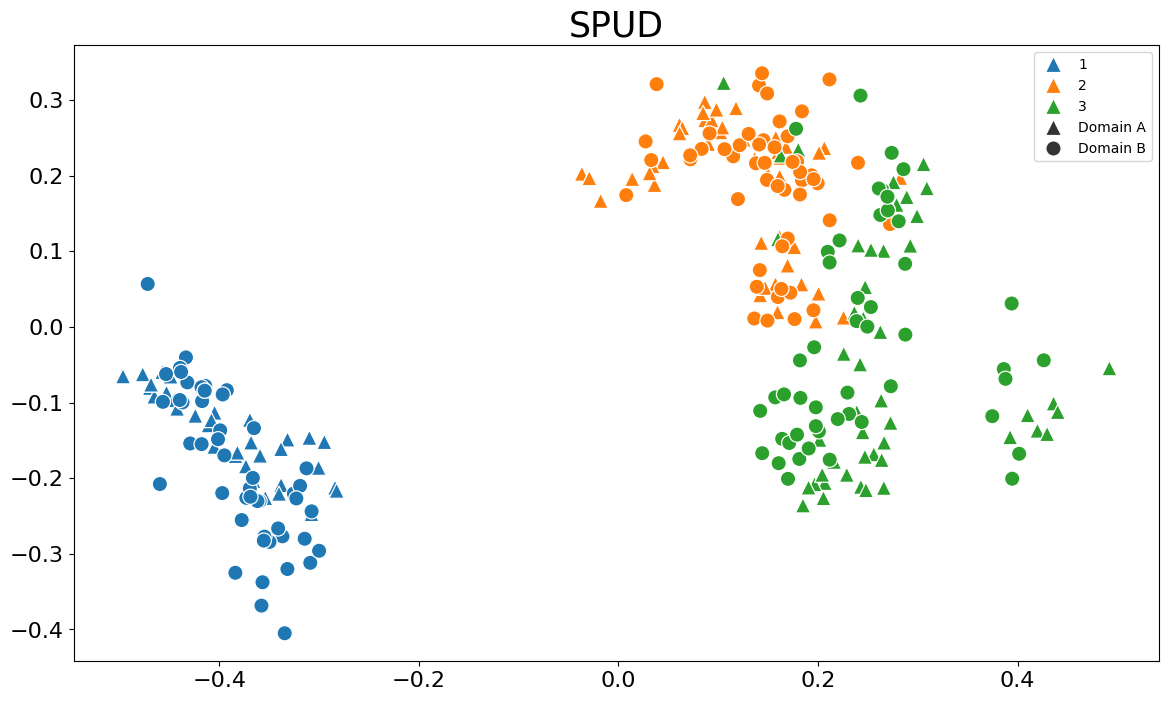

In [14]:
# Get data ready
from Main.test_manifold_algorithms import test_manifold_algorithms as tma
from mashspud import SPUD 
from Helpers.Grae import *

dc4 = tma("iris.csv", split = "even", verbose = 5, random_state=12)

spud = SPUD(knn = 4)
spud.fit(dc4.split_A, dc4.split_B, known_anchors=dc4.anchors[:10])
spud.get_scores(dc4.labels_doubled, n_components = dc4.n_comp)
spud.plot_emb(dc4.labels_doubled, show_anchors = False, show_lines = False)

In [15]:
split_A = BaseDataset(x = dc4.split_A, y = dc4.labels, split_ratio = 0.8, random_state = 42, split = "none")
myGraeA = GRAEBase(n_components = dc4.n_comp)
myGraeA.fit(split_A, emb=spud.emb[:spud.len_A]) 


split_B = BaseDataset(x = dc4.split_B, y = dc4.labels, split_ratio = 0.8, random_state = 42, split = "none")
myGraeB = GRAEBase(n_components = dc4.n_comp)
myGraeB.fit(split_B, emb=spud.emb[spud.len_A:])

In [16]:
#Convert A to embedding
data = myGraeA.transform(split_A)

#Convert embedding to B
data_inv = myGraeB.inverse_transform(data)

#Convert it going the other way
split_B_pred = BaseDataset(x = data_inv, y = dc4.labels, split_ratio = 0.8, random_state = 42, split = "none")
a_reconstructed = myGraeA.inverse_transform(myGraeB.transform(split_B_pred))


In [17]:
split_B.numpy()[0].shape

(150, 2)

Text(0.5, 1.0, 'Domain A Plotted')

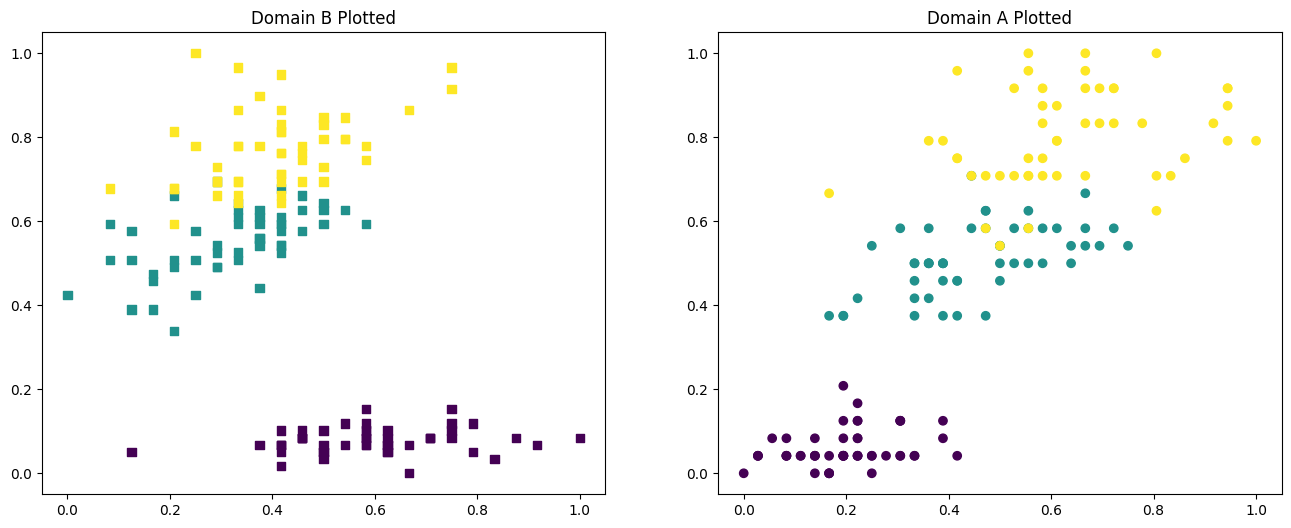

In [18]:
# Plot the embeddings
def reshape_data(data, index):
    feature_amount = data.shape[1]
    if feature_amount < 2:
        print(f"Data has less than 2 features")
        return data
    elif feature_amount > 2:
        print(f"Data has more than 2 features. Using PCA")
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        return pca.fit_transform(data)[:, index]
    else:
        return data[:, index]
    
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the first embedding on the first subplot
axes[0].scatter(x=reshape_data(split_B.numpy()[0], 0), y=reshape_data(split_B.numpy()[0], 1), c=split_B.numpy()[1], marker="s")
axes[0].set_title("Domain B Plotted")

# Plot the second embedding on the second subplot
axes[1].scatter(x = reshape_data(split_A.numpy()[0], 0), y = reshape_data(split_A.numpy()[0], 1), c = split_A.numpy()[1])
axes[1].set_title("Domain A Plotted")

Text(0.5, 1.0, 'Domain A translated back to itself\nRMSE: 0.07377525240068213')

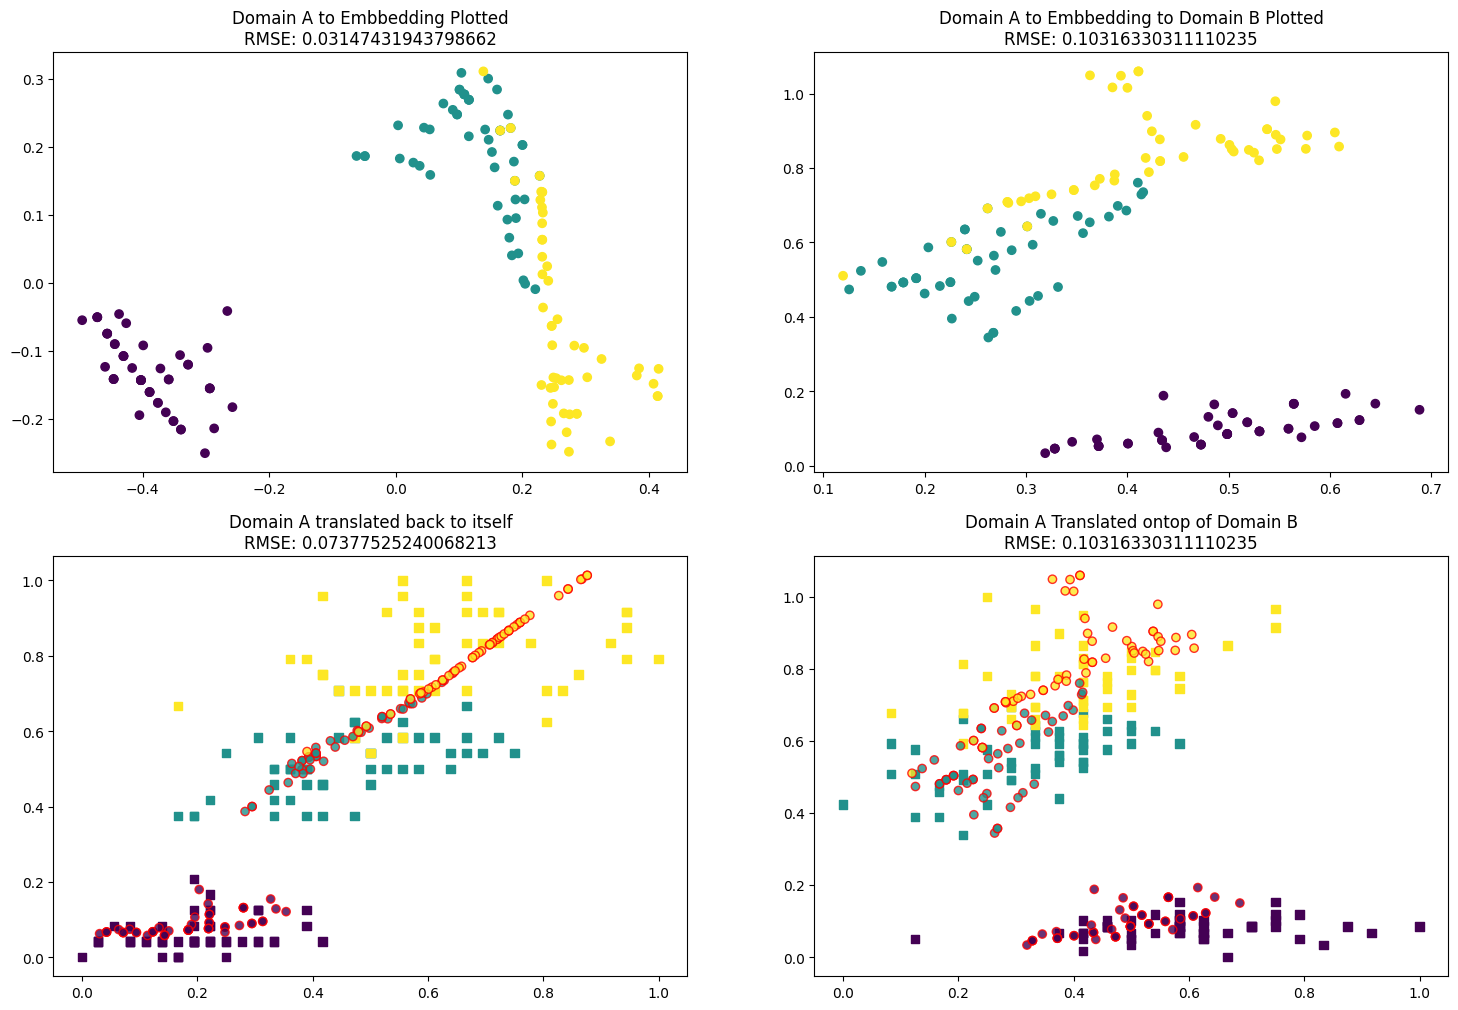

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

#Print error
from sklearn.metrics import root_mean_squared_error
score_text = "\nRMSE: " + str(root_mean_squared_error(data, spud.emb[:spud.len_A]))
axes[0,0].scatter(x = data[:, 0], y = data[:, 1], c = split_A.numpy()[1])
axes[0,0].set_title("Domain A to Embbedding Plotted" + score_text)

score_text = "\nRMSE: " + str(root_mean_squared_error(data_inv, dc4.split_B))
axes[0,1].scatter(x = reshape_data(data_inv, 0), y = reshape_data(data_inv, 1), c = split_A.numpy()[1])
axes[0,1].set_title("Domain A to Embbedding to Domain B Plotted" + score_text)

axes[1,1].scatter(x = reshape_data(split_B.numpy()[0], 0), y = reshape_data(split_B.numpy()[0], 1), c = split_B.numpy()[1], marker = "s")
axes[1,1].scatter(x = reshape_data(data_inv, 0), y = reshape_data(data_inv, 1), c = split_A.numpy()[1], alpha = 0.8,  edgecolor='red')
axes[1,1].set_title("Domain A Translated ontop of Domain B" + score_text)


score_text = "\nRMSE: " + str(root_mean_squared_error(a_reconstructed, dc4.split_A))
axes[1,0].scatter(x = reshape_data(split_A.numpy()[0], 0), y = reshape_data(split_A.numpy()[0], 1), c = split_A.numpy()[1], marker = "s")
axes[1,0].scatter(x = reshape_data(a_reconstructed, 0), y = reshape_data(a_reconstructed, 1), c = split_A.numpy()[1], alpha = 0.8, edgecolor='red')
axes[1,0].set_title("Domain A translated back to itself" + score_text)

# Unique Loss Function

## The Parts of the loss function 
- Loss from A to Z layer back to A (Standard)
- Loss from anchors in A to Z layer to B (Weight more?)
- Loss from points from A to Z layer to B domain back to Z to A. 


MDS initialized with 2 components

 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)
RF score on full embedding: 0.8533333333333334
Cross Embedding score: None
Fraction of Samples Closest to thier Match: 0.0008888888888888888


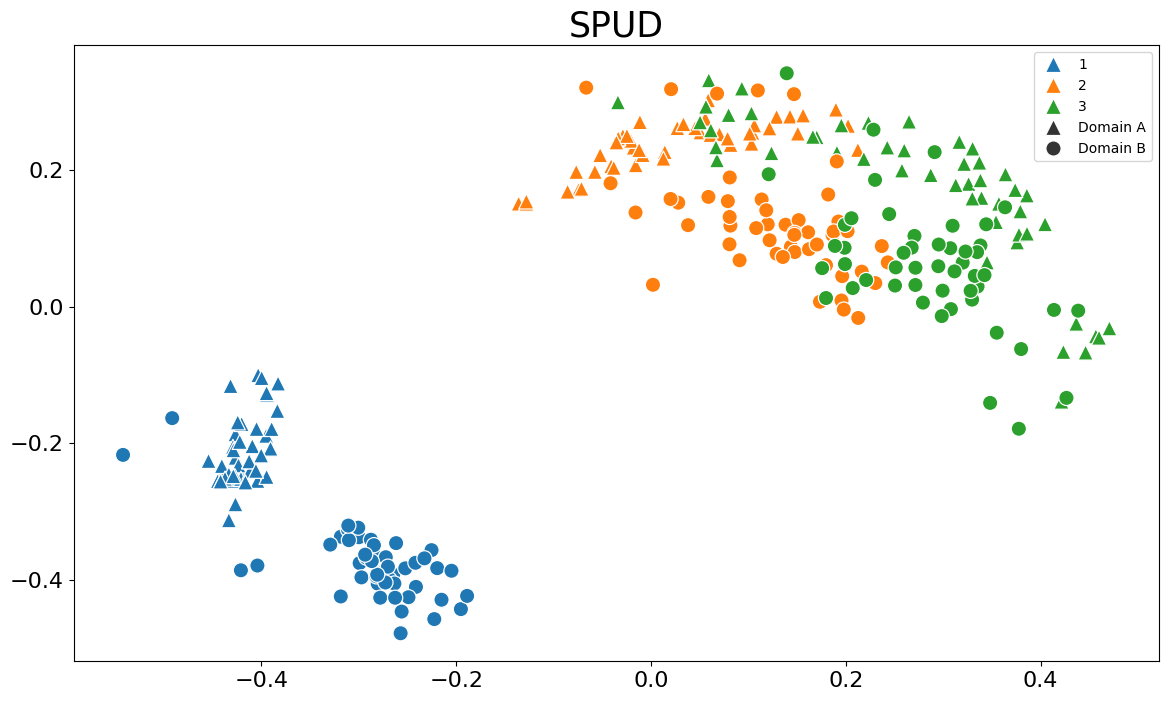

In [1]:
# Get data ready
from Main.test_manifold_algorithms import test_manifold_algorithms as tma
from mashspud import SPUD 
from Helpers.Grae import *

dc4 = tma("iris.csv", split = "even", verbose = 5, random_state=12)

spud = SPUD(knn = 4)
spud.fit(dc4.split_A, dc4.split_B, known_anchors=dc4.anchors[:50])
spud.get_scores(dc4.labels_doubled, n_components = dc4.n_comp)
spud.plot_emb(dc4.labels_doubled, show_anchors = False, show_lines = False)

In [2]:
DomainT = DomainTranslation(Akwargs = {"n_components": dc4.n_comp}, Bkwargs = {"n_components": dc4.n_comp})
DomainT.fit(dc4.split_A, dc4.split_B, dc4.labels, emb=spud.emb, known_anchors=dc4.anchors[:50], epochs = 200)

Fitting GRAE modules...

Preparing Anchor Data...

 ---------------------------------
Beginning Training Loop...
Epoch 0, Loss: 0.10921861976385117
Epoch 1, Loss: 0.1709689199924469
Epoch 2, Loss: 0.08493155986070633
Epoch 3, Loss: 0.08721691370010376
Epoch 4, Loss: 0.06575142592191696
Epoch 5, Loss: 0.07389144599437714
Epoch 6, Loss: 0.09606552124023438
Epoch 7, Loss: 0.04067355394363403
Epoch 8, Loss: 0.07979919016361237
Epoch 9, Loss: 0.11881919950246811
Epoch 10, Loss: 0.0639021247625351
Epoch 11, Loss: 0.16530609130859375
Epoch 12, Loss: 0.07455181330442429
Epoch 13, Loss: 0.06715893745422363
Epoch 14, Loss: 0.12304069846868515
Epoch 15, Loss: 0.0624505877494812
Epoch 16, Loss: 0.06950990110635757
Epoch 17, Loss: 0.07676149159669876
Epoch 18, Loss: 0.0945444405078888
Epoch 19, Loss: 0.09612059593200684
Epoch 20, Loss: 0.08754559606313705
Epoch 21, Loss: 0.08299825340509415
Epoch 22, Loss: 0.1739884614944458
Epoch 23, Loss: 0.14866472780704498
Epoch 24, Loss: 0.08592789620161057
Ep

Text(0.5, 1.0, 'Domain A Plotted')

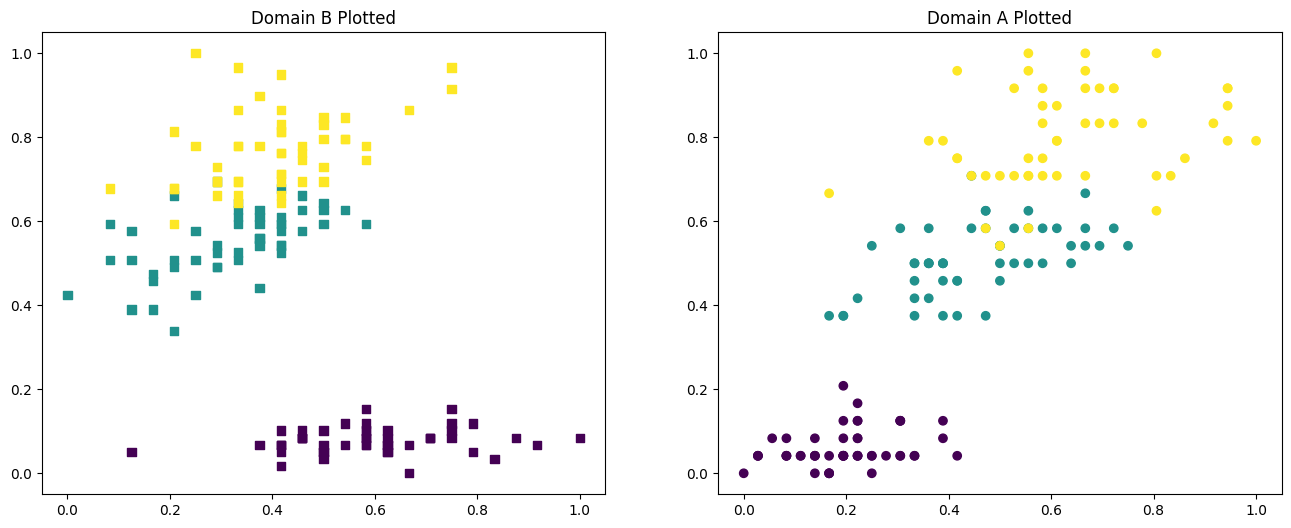

In [3]:
#Get datasets
split_A = BaseDataset(x = dc4.split_A, y = dc4.labels, split_ratio = 0.8, random_state = 42, split = "none")
split_B = BaseDataset(x = dc4.split_B, y = dc4.labels, split_ratio = 0.8, random_state = 42, split = "none")

#Convert A to embedding
data = DomainT.graeA.transform(split_A)

#Convert embedding to B
data_inv = DomainT.graeB.inverse_transform(data)

#Convert it going the other way
split_B_pred = BaseDataset(x = data_inv, y = dc4.labels, split_ratio = 0.8, random_state = 42, split = "none")
a_reconstructed = DomainT.graeA.inverse_transform(DomainT.graeB.transform(split_B_pred))

# Plot the embeddings
def reshape_data(data, index):
    feature_amount = data.shape[1]
    if feature_amount < 2:
        print(f"Data has less than 2 features")
        return data
    elif feature_amount > 2:
        print(f"Data has more than 2 features. Using PCA")
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        return pca.fit_transform(data)[:, index]
    else:
        return data[:, index]
    
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the first embedding on the first subplot
axes[0].scatter(x=reshape_data(split_B.numpy()[0], 0), y=reshape_data(split_B.numpy()[0], 1), c=split_B.numpy()[1], marker="s")
axes[0].set_title("Domain B Plotted")

# Plot the second embedding on the second subplot
axes[1].scatter(x = reshape_data(split_A.numpy()[0], 0), y = reshape_data(split_A.numpy()[0], 1), c = split_A.numpy()[1])
axes[1].set_title("Domain A Plotted")

Text(0.5, 1.0, 'Domain A translated back to itself\nRMSE: 0.0786968313836246')

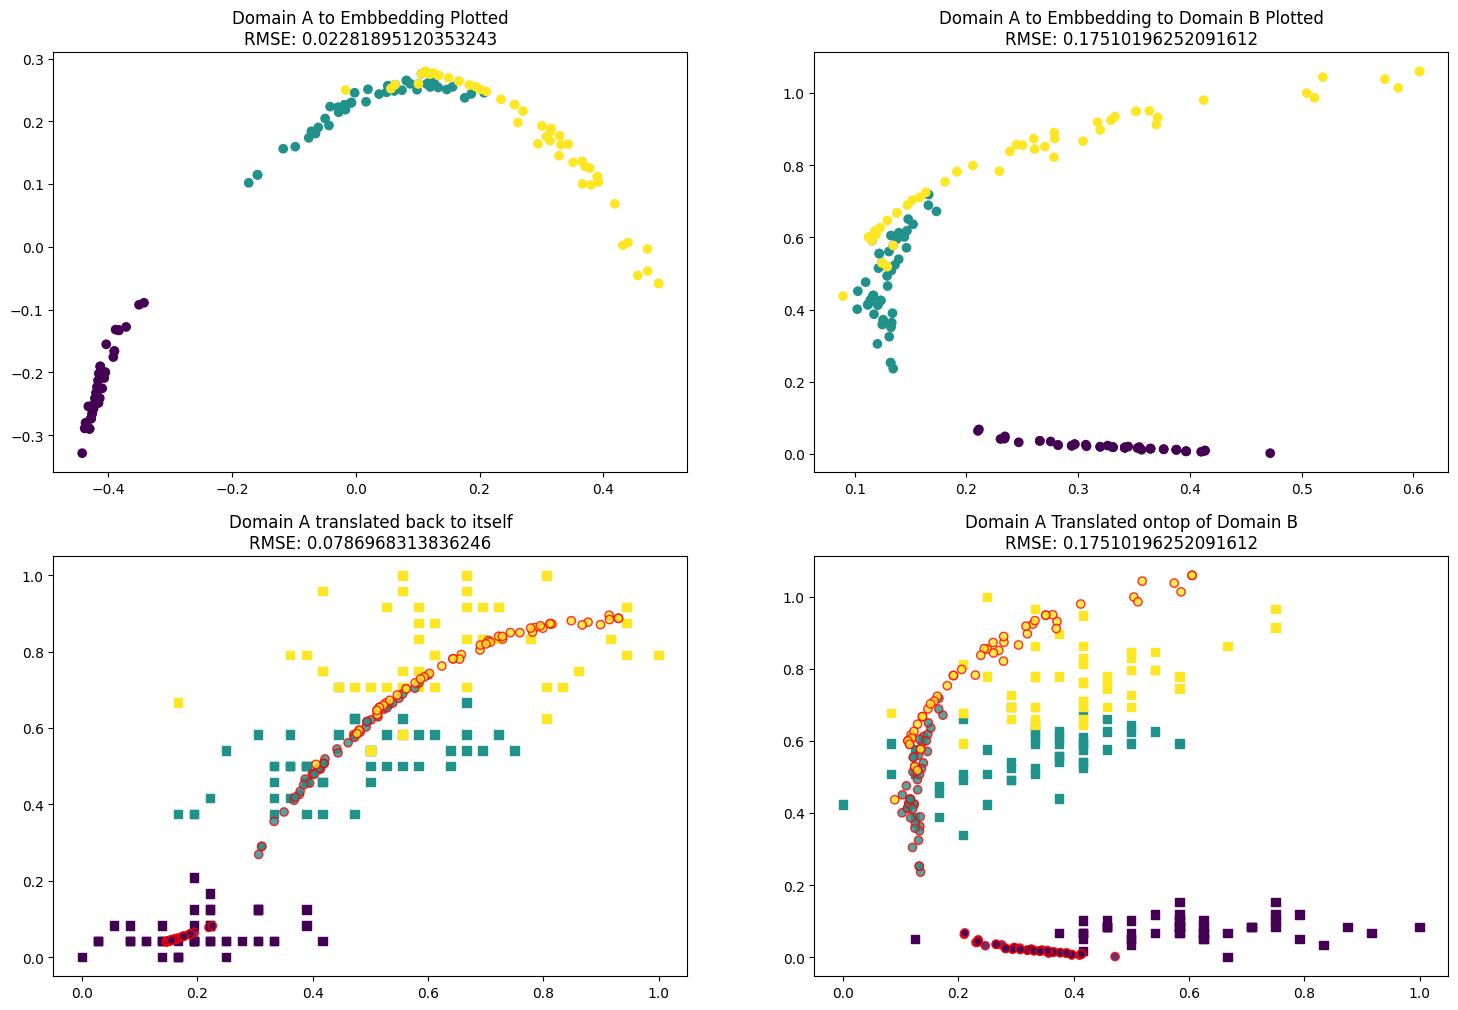

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

#Print error
from sklearn.metrics import root_mean_squared_error
score_text = "\nRMSE: " + str(root_mean_squared_error(data, spud.emb[:spud.len_A]))
axes[0,0].scatter(x = data[:, 0], y = data[:, 1], c = split_A.numpy()[1])
axes[0,0].set_title("Domain A to Embbedding Plotted" + score_text)

score_text = "\nRMSE: " + str(root_mean_squared_error(data_inv, dc4.split_B))
axes[0,1].scatter(x = reshape_data(data_inv, 0), y = reshape_data(data_inv, 1), c = split_A.numpy()[1])
axes[0,1].set_title("Domain A to Embbedding to Domain B Plotted" + score_text)

axes[1,1].scatter(x = reshape_data(split_B.numpy()[0], 0), y = reshape_data(split_B.numpy()[0], 1), c = split_B.numpy()[1], marker = "s")
axes[1,1].scatter(x = reshape_data(data_inv, 0), y = reshape_data(data_inv, 1), c = split_A.numpy()[1], alpha = 0.8,  edgecolor='red')
axes[1,1].set_title("Domain A Translated ontop of Domain B" + score_text)


score_text = "\nRMSE: " + str(root_mean_squared_error(a_reconstructed, dc4.split_A))
axes[1,0].scatter(x = reshape_data(split_A.numpy()[0], 0), y = reshape_data(split_A.numpy()[0], 1), c = split_A.numpy()[1], marker = "s")
axes[1,0].scatter(x = reshape_data(a_reconstructed, 0), y = reshape_data(a_reconstructed, 1), c = split_A.numpy()[1], alpha = 0.8, edgecolor='red')
axes[1,0].set_title("Domain A translated back to itself" + score_text)

# TAEROE tests

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def scatter_plot(x, y, labels, title="Scatter Plot", colormap="viridis", emb = None, domain = None):
    # Ensure labels is a numpy array
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    # Create a colormap with as many colors as needed
    colors = plt.cm.get_cmap(colormap, len(unique_labels))
    
    plt.figure(figsize=(8,6))
    
    for i, label in enumerate(unique_labels):
        idx = labels == label
        plt.scatter(x[idx], y[idx], label=str(label), color=colors(i), s=70, alpha=0.8, edgecolor='black')
    
    if emb is not None:
        # Plot emb points as triangles; assuming emb is a (n,2) array
        plt.scatter(emb[:,0], emb[:,1], label="emb", marker="^", c=np.hstack([labels, labels]), s=40, alpha=0.8, edgecolor='black')

    if domain is not None:
        # Plot emb points as triangles; assuming emb is a (n,2) array
        plt.scatter(domain[:,0], domain[:,1], label="Domain", marker="d", c=labels, s=40, alpha=0.8, edgecolor='black')

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

MDS initialized with 2 components

 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)
RF score on full embedding: 0.8533333333333334
Cross Embedding score: None
Fraction of Samples Closest to thier Match: 0.0008888888888888888


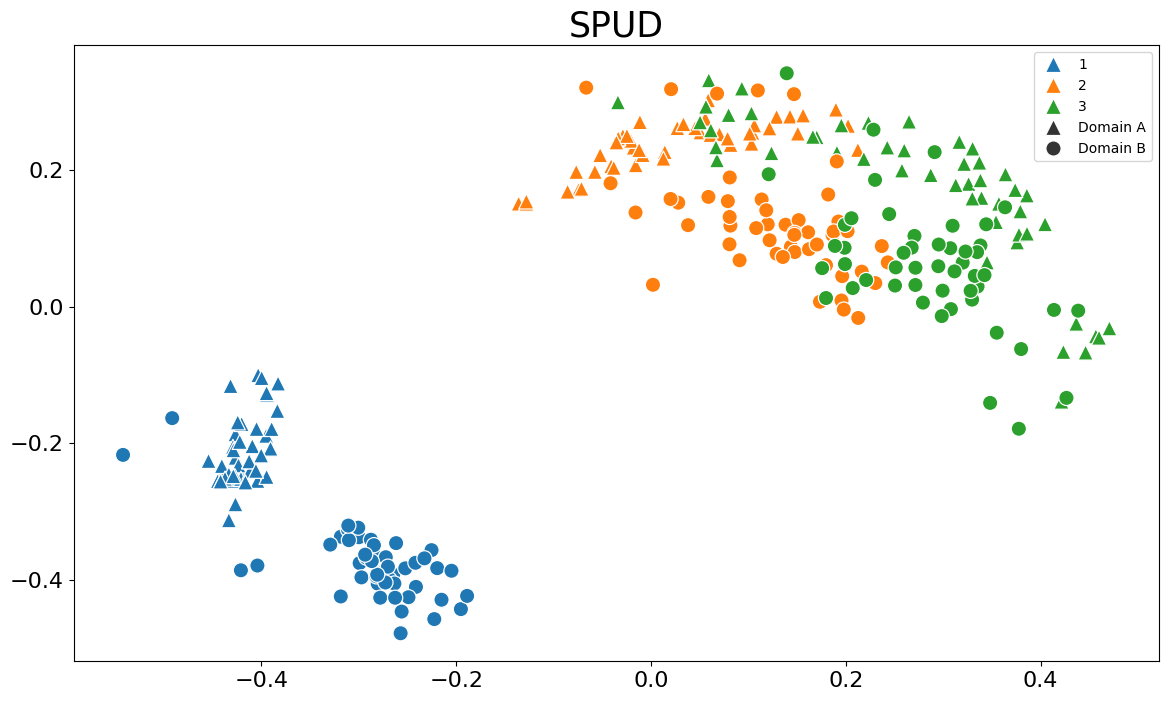

In [3]:
# Get data ready
from Main.test_manifold_algorithms import test_manifold_algorithms as tma
from mashspud import SPUD 
from Helpers.Grae import *

dc5 = tma("iris.csv", split = "even", verbose = 5, random_state=12)

spud = SPUD(knn = 4)
spud.fit(dc5.split_A, dc5.split_B, known_anchors=dc5.anchors[:50])
spud.get_scores(dc5.labels_doubled, n_components = dc5.n_comp)
spud.plot_emb(dc5.labels_doubled, show_anchors = False, show_lines = False)

In [15]:
taro = TAEROE(verbose = 1, Akwargs = {"n_components": dc5.n_comp}, Bkwargs = {"n_components": dc5.n_comp}, SGkwargs = {"comet_exp" : 1})
# Batch size | epochs | learning rate (fine tuning) | lambda (regularization) 

In [16]:
taro.fit(dc5.split_A, dc5.split_B, emb=spud.emb, known_anchors=dc5.anchors[:50],
          labelsA = dc5.labels, labelsB = dc5.labels)

Fitting GRAE modules...

------------------------------------------------
Beginning Training Loop for Swapped model...


ValueError: too many values to unpack (expected 2)

In [6]:
a, b, a_z, b_z = taro.transform(dc5.split_A)

In [7]:
a.shape, b.shape, a_z.shape, b_z.shape

((150, 2), (150, 2), (150, 2), (150, 2))

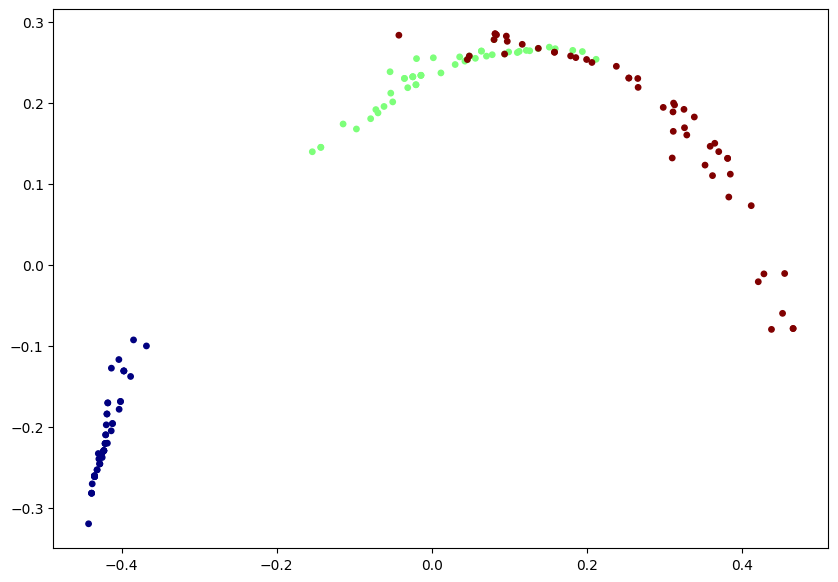

In [8]:
taro.graeA.plot(BaseDataset(x = dc5.split_A, y = dc5.labels, split_ratio = 0.8, random_state = 42, split = "none"))

/tmp/ipykernel_567346/2295398660.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(colormap, len(unique_labels))


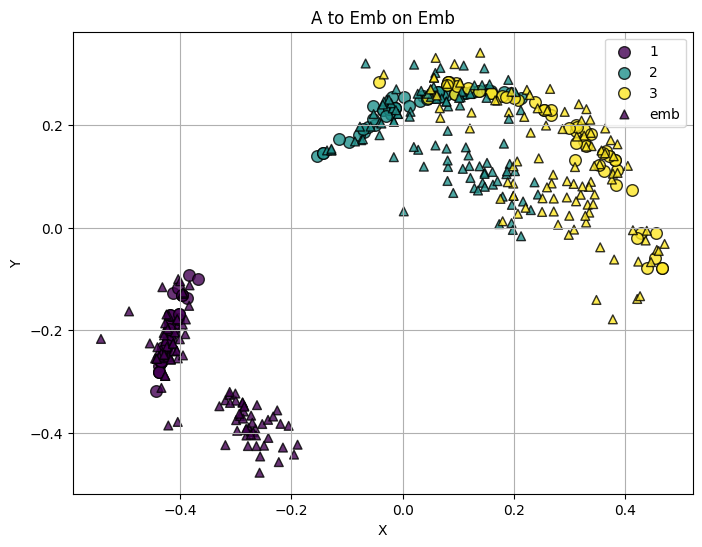

In [9]:
scatter_plot(a_z[:,0], a_z[:,1], dc5.labels, title="A to Emb on Emb", emb = spud.emb)

/tmp/ipykernel_567346/2295398660.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(colormap, len(unique_labels))


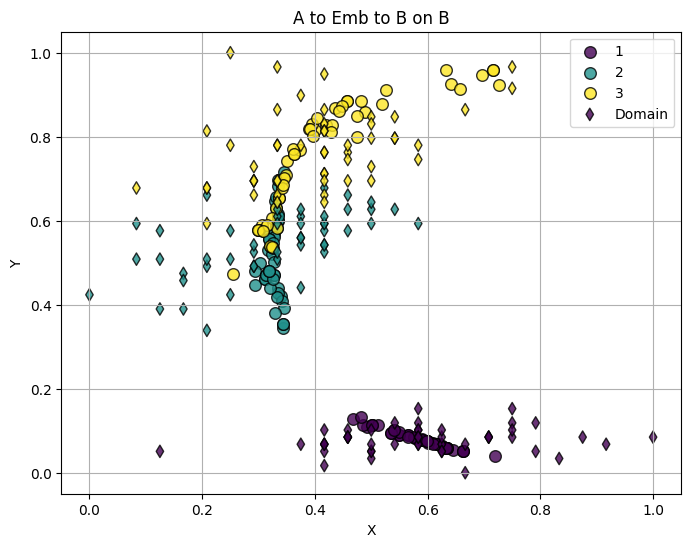

In [10]:
scatter_plot(b[:,0], b[:,1], dc5.labels, title="A to Emb to B on B", domain = dc5.split_B)

/tmp/ipykernel_567346/2295398660.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(colormap, len(unique_labels))


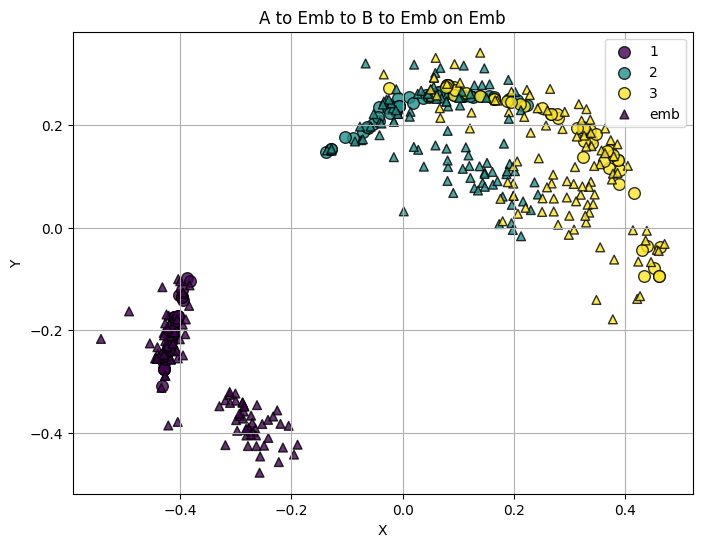

In [11]:
scatter_plot(b_z[:,0], b_z[:,1], dc5.labels, title="A to Emb to B to Emb on Emb", emb = spud.emb)

/tmp/ipykernel_567346/2295398660.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(colormap, len(unique_labels))


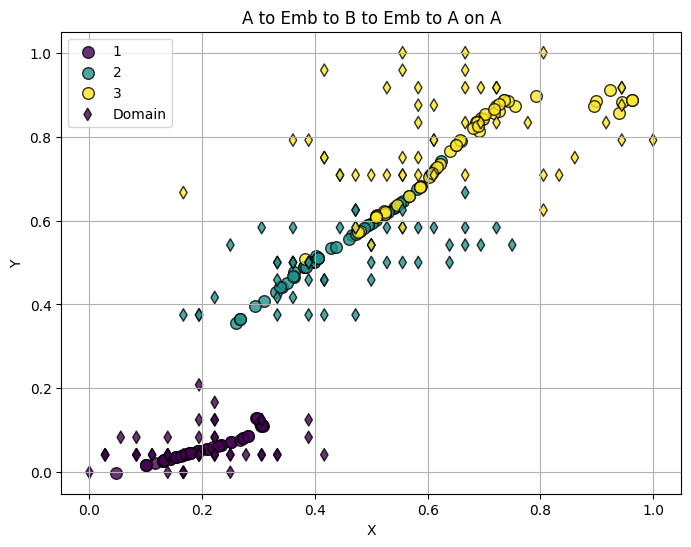

In [12]:
scatter_plot(a[:,0], a[:,1], dc5.labels, title="A to Emb to B to Emb to A on A", domain = dc5.split_A)

In [13]:
# Try to see the prediction accuracy yet